In [ ]:
# Deriving Christchurch Landuse from OSM

In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd

In [43]:
# setting blanket crs
crs = 'EPSG:2124'

<Axes: >

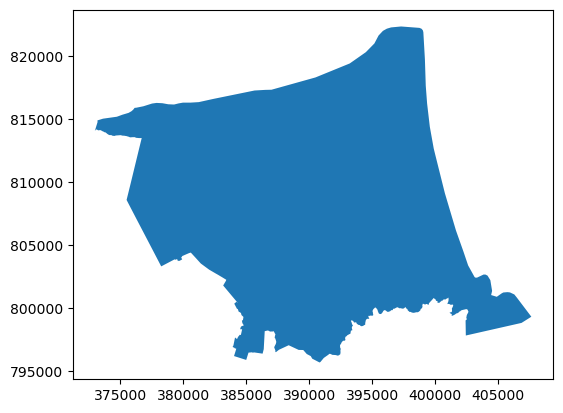

In [44]:
christchurch = 'Christchurch, New Zealand'

# Check boundary is correct
chc = ox.geocode_to_gdf(christchurch)
chc = chc.to_crs(crs)
chc.plot()

In [46]:
# get waterways an railways as geometries
waterways = ox.features_from_place(christchurch, tags={'waterway': True})
railways = ox.features_from_place(christchurch, tags={'railway': True})

# Create a geodataframe from each, applying the meblourne CRS to the dataframes 
# (based on crs used in sentinel-1 method, EPSG:6283)
waterways_gdf = gpd.GeoDataFrame(waterways)
railways_gdf = gpd.GeoDataFrame(railways)

railways_gdf = railways_gdf.to_crs(crs)
waterways_gdf = waterways_gdf.to_crs(crs)

In [47]:
# Choosing road types from the highways tag in OSM to act as city block boundaries
network_tags = {'highway':['motorway','trunk',
                          'primary','secondary',
                          'tertiary','residential',
                          'unclassified','motorway_link',
                          'trunk_link','primary_link',
                          'secondary_link','tertiary_link',
                          'living_street']
                }

In [48]:
# deriving a geodataframe based on the roads specified in buffer function
roads = ox.features_from_place(christchurch, tags=network_tags)
roads_gdf = roads.to_crs(crs)

In [49]:
# I only want geometry types that are linestring for creating boundaries, so drop all other kinds

# Railways:
railways_gdf = railways_gdf[railways_gdf.geometry.type == 'LineString']

# Waterways:
waterways_gdf = waterways_gdf[waterways_gdf.geometry.type == 'LineString']

# Roads:
roads_gdf = roads_gdf[roads_gdf.geometry.type == 'LineString']

In [50]:
# Define a function to buffer line features with variable widths

# The buffer is being used to ensure that any unused space between the network and
# the land use is not being considered. eg. spaces directly next to railways are
# not going to be publicly accessible
def buffer_lines(lines_gdf):
    # Different buffer widths will be used dependning on the feature, chosen based on best guesses
    # buffer widths need to be adjusted to fit crs.
    buffer_widths = {
        'motorway':8,
        'trunk':5,
        'primary':5,
        'secondary':4,
        'tertiary':4,
        'residential':3,
        'unclassified':2,
        'motorway_link':8,
        'trunk_link':5,
        'primary_link':5,
        'secondary_link':4,
        'tertiary_link':4,
        'living_street':4
    }
    lines_gdf['buffered_geometry'] = lines_gdf.apply(
        lambda row: row['geometry'].buffer(buffer_widths.get(row['highway'], 0)), axis=1)
    return lines_gdf

<Axes: >

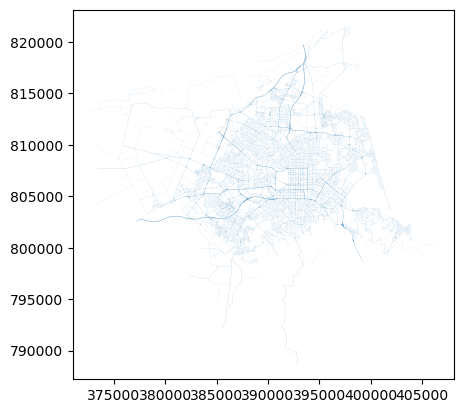

In [51]:
roads_gdf = buffer_lines(roads_gdf)
roads_gdf['buffered_geometry'].plot()

In [52]:
# For railways and waterways, no function needs to be defined
railways_gdf['buffered_geometry'] = railways_gdf.apply(lambda row: row['geometry'].buffer(5, 0), axis=1)
waterways_gdf['buffered_geometry'] = waterways_gdf.apply(lambda row: row['geometry'].buffer(10, 0), axis=1)

In [53]:
# Set crs of buffered geometry columns
roads_gdf['buffered_geometry'] = roads_gdf['buffered_geometry'].set_crs(crs)
railways_gdf['buffered_geometry'] = railways_gdf['buffered_geometry'].set_crs(crs)
waterways_gdf['buffered_geometry'] = waterways_gdf['buffered_geometry'].set_crs(crs)

In [54]:
# creating a dataframe of just buffered geometry
road_buffers = roads_gdf
road_buffers['geometry'] = road_buffers['buffered_geometry']
road_buffers = road_buffers.drop(columns='buffered_geometry')

# railways:
railway_buffers = railways_gdf
railway_buffers['geometry'] = railway_buffers['buffered_geometry']
railway_buffers = railway_buffers.drop(columns=['buffered_geometry','highway'])

# waterways:
waterway_buffers = waterways_gdf
waterway_buffers['geometry'] = waterway_buffers['buffered_geometry']
waterway_buffers = waterway_buffers.drop(columns='buffered_geometry')

In [55]:
# Merge waterways and railways with the street network
merged_buffers = gpd.overlay(road_buffers, waterway_buffers, how='union')
merged_buffers = gpd.overlay(merged_buffers, railway_buffers, how='union')

/tmp/ipykernel_2519514/4244350629.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 28 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  merged_buffers = gpd.overlay(merged_buffers, railway_buffers, how='union')


<Axes: >

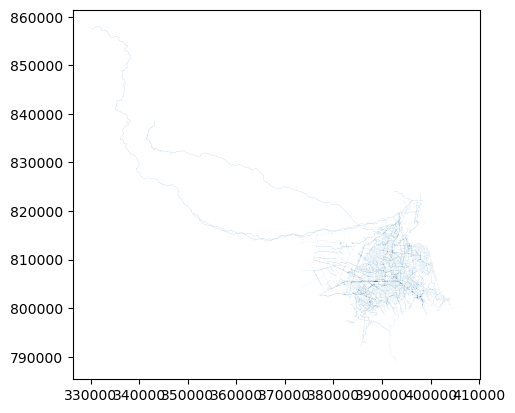

In [56]:
merged_buffers.plot()

In [57]:
# I want to clip the buffer dataframe to the boundary of christchurch
merged_buffers = gpd.clip(merged_buffers, chc)

In [58]:
# using this, i can derive polygons shown in green using the difference function in gpd
# Calculate the difference between the city polygon and the road network
areas_with_no_roads = chc.difference(merged_buffers.unary_union)

In [59]:
# divide multipolgon into set of polygons
city_blocks = areas_with_no_roads.explode(index_parts=True)

# create a geodataframe for these areas
city_blocks = gpd.GeoDataFrame(geometry=city_blocks, crs=chc.crs)

In [61]:
city_blocks = city_blocks.to_crs(crs)
city_blocks.crs

<Projected CRS: EPSG:2124>
Name: NZGD2000 / Mount Pleasant 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - South Island - Mount Pleasant meridional circuit area.
- bounds: (171.11, -43.96, 173.38, -42.69)
Coordinate Operation:
- name: Mount Pleasant 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [62]:
# Finding the area of each city block identified:
city_blocks['area'] = city_blocks['geometry'].area

In [63]:
# identify any city blocks with an area less than 10 metres
tiny_blocks = city_blocks[city_blocks['area'] < 10]
print('There are', len(tiny_blocks), 'city blocks less than 10m in Christchurch.')

There are 245 city blocks less than 10m in Christchurch.


## Tags from OSM associated with greenspace

In [64]:
greenspace_tags = {'landuse':['flowerbed','forest',
                              'greenhouse_horticulture',
                              'meadow','orchard',
                              'plant_nursery','vineyard',
                              'grass','greenfield','village_green'],
                   'leisure':['dog_park','garden','golf_course',
                              'nature_reserve','park','pitch']
                  }
                     

In [66]:
greenspace = ox.features_from_place(christchurch, tags=greenspace_tags)
greenspace_gdf = greenspace.to_crs(crs)
greenspace_gdf = greenspace_gdf[greenspace_gdf.geometry != 'Point']

## Adding building footprints to the map

For the most part, buildings are typically areas where there is no greenspace. however, things like rooftop and vertical gardens cannot be ruled out.

In [67]:
buildings = ox.features_from_place(christchurch, tags={'building':True})
buildings_gdf = buildings.to_crs(crs)

In [68]:
# removing points so only polygons are representing the footprints
buildings_gdf = buildings_gdf[buildings_gdf.geometry.type == 'Polygon']

## Finding Public Parks

In [69]:
# Locating all of the parks in Melbourne
parks = ox.features_from_place(christchurch, tags={'leisure':'park'})
parks_gdf = parks.to_crs(crs)

In [70]:
# showing only parks that are not private according to OSM. There are two locations that are tagged as private
public_parks_gdf = parks_gdf[parks_gdf['access'] != 'private']

Text(0.5, 1.0, 'Christchurch City')

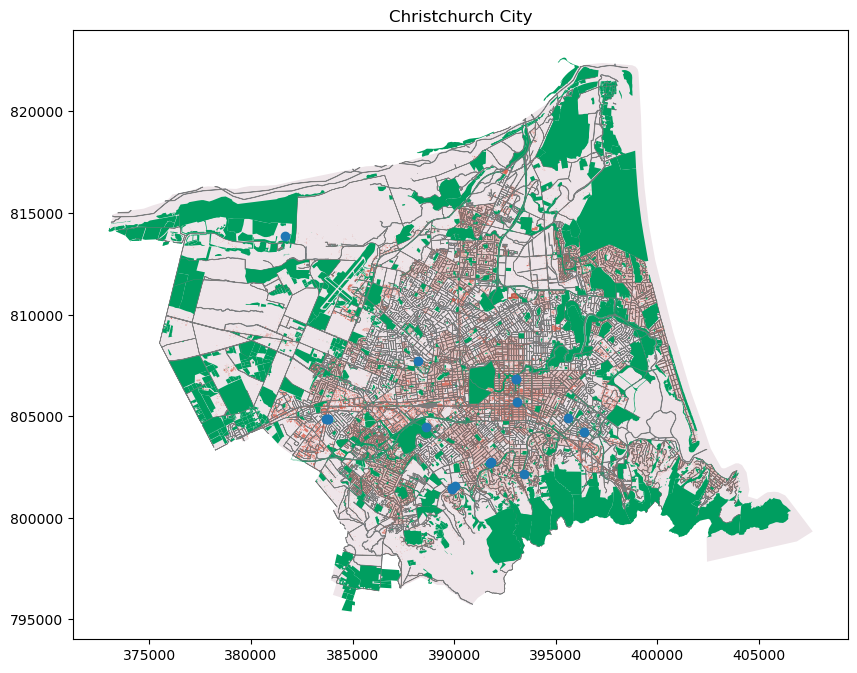

In [73]:
# Visualise in a single figure all the OSM data that was foud:
# Create a figure and an axis for plotting, and set the figure size
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each of the GeoDataFrames on the plotting axis to ensure they are all on the same figure
# Plot the 'area' GeoDataFrame with black face color
chc.plot(ax=ax, facecolor="#EEE5E9")

# edges geodataframe
merged_buffers.plot(ax=ax, linewidth=0.5, edgecolor="#7C7C7C", label='City Block Boundaries')

# hospitals geodataframe
buildings_gdf.plot(ax=ax, facecolor="#D64933", alpha=0.7, label='Buildings')

# greenspace
greenspace_gdf.plot(ax=ax, facecolor='#009E60', label='Parks')

# private parks

#plt.legend()
ax.set_title('Christchurch City')